In [1]:
import sys, os
from pathlib import Path
sys.path.append(str(Path('impl.ipynb').resolve().parents[3]))
from prep.params import SQLITE_PATH, CO_DETR_DIR
from prep.sqlitedb import MetadataDB

db = MetadataDB("../../"+SQLITE_PATH)
if db.check_table_exists("Video"):
    video_ids = [video[0] for video in db.fetch_videos()]
    print(f"There are {len(video_ids)} videos in the database, ids as below:")
    print(video_ids)

Tables 'Video' created or already exist.
There are 3 videos in the database, ids as below:
['07187f01-642c-49ed-9b23-e0aec49fb9b4', 'b372dd52-027d-47d1-8c08-d4fb38f8230d', 'b6a50236-bed1-4e87-9779-47a37138bbd7']


In [3]:
from PIL import Image
import torch, requests, os
from transformers import DetrImageProcessor, DetrForObjectDetection
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

processor = DetrImageProcessor.from_pretrained("../../"+CO_DETR_DIR)
model = DetrForObjectDetection.from_pretrained("../../"+CO_DETR_DIR)

model.to(device)
model.eval()

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [35]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])

# let's only keep detections with score > 0.9
results = processor.post_process_object_detection(outputs, 
                                                  target_sizes=target_sizes, 
                                                  threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected cat with confidence 0.998 at location [344.06, 24.85, 640.34, 373.74]
Detected remote with confidence 0.997 at location [328.13, 75.93, 372.81, 187.66]
Detected remote with confidence 0.997 at location [39.34, 70.13, 175.56, 118.78]
Detected cat with confidence 0.998 at location [15.36, 51.75, 316.89, 471.16]
Detected couch with confidence 0.995 at location [-0.19, 0.71, 639.73, 474.17]


In [ ]:
# Vizualize the results
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(12, 12))
plt.imshow(image)
ax = plt.gca()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box]
    rect = patches.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1],
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    plt.text(box[0], box[1], f"{model.config.id2label[label.item()]}: {score:.2f}",
             bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12, color='black')
plt.axis('off')
plt.show()

### Load from class

In [1]:
from ObjDetect import ObjectDetector
import requests, sys
from PIL import Image
from pathlib import Path
sys.path.append(str(Path('impl.ipynb').resolve().parents[3]))


url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Image to base64
import base64
from io import BytesIO
def image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

image_base64 = image_to_base64(image)

detector = ObjectDetector()
results = detector.detect(image_base64)

/Users/dna-tuananguyen/anaconda3/envs/apitcdk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results

{'boxes': [[343.1755065917969,
   24.767948150634766,
   640.4005126953125,
   373.996826171875],
  [327.0817565917969,
   75.79769897460938,
   372.8892517089844,
   188.01234436035156],
  [38.136959075927734,
   69.69452667236328,
   176.1708221435547,
   119.78018188476562],
  [15.481481552124023, 51.99665832519531, 315.6678771972656, 470.614501953125],
  [-0.20952224731445312,
   0.6423282623291016,
   639.7437133789062,
   474.6432800292969]],
 'scores': [0.9985529780387878,
  0.9981963038444519,
  0.9942688941955566,
  0.997520387172699,
  0.9922892451286316],
 'labels': ['cat', 'remote', 'remote', 'cat', 'couch']}

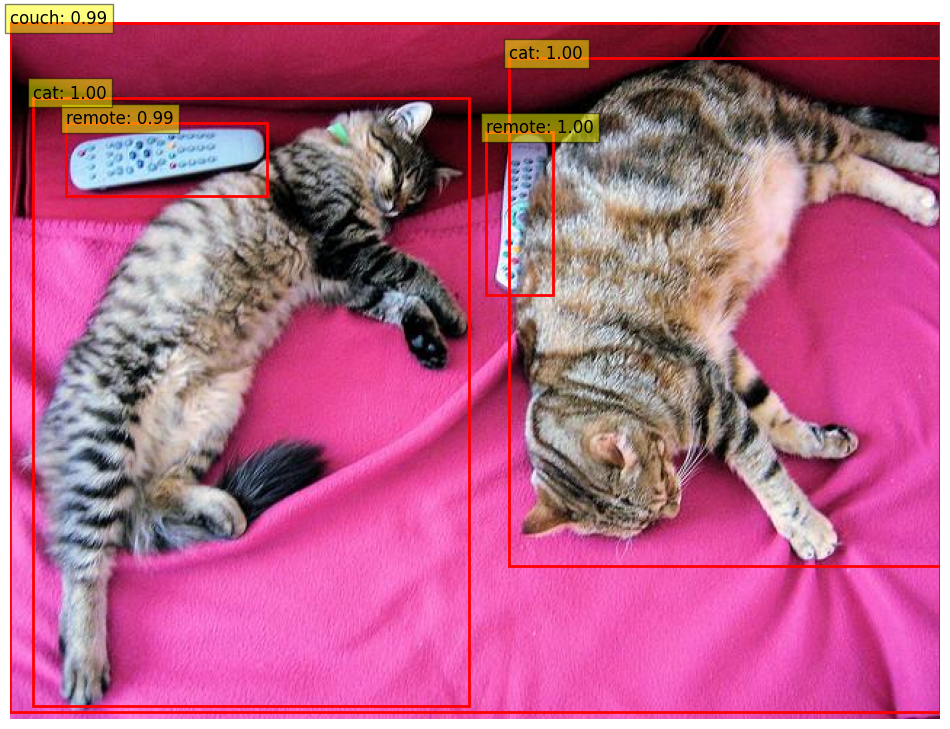

In [3]:
detector.visualize(image_base64)